In [33]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
%autoreload 2

In [35]:
from argparse import Namespace

In [36]:
# Simulate the prediction
args = Namespace()
args.config_file = "configs/SOTR/R_101_DCN_doc.yaml"
args.resume = False
args.eval_only = True
args.num_gpus =1
args.num_machines=1
args.machine_rank = 0
args.dist_url = "tcp://127.0.0.1:8080"
args.opts = ["MODEL.WEIGHTS", "weights/model_final.pth"]

In [37]:
from tools.train_net_custom import setup, Trainer
from detectron2.utils.visualizer import Visualizer
from adet.checkpoint import AdetCheckpointer
from tools.visualize_publaynet import create_instances

In [38]:
cfg = setup(args)

[08/01 23:01:16 detectron2]: Rank of current process: 0. World size: 1
[08/01 23:01:16 detectron2]: Environment info:
----------------------  --------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.7.11 (default, Jul 27 2021, 14:32:16) [GCC 7.5.0]
numpy                   1.21.5
detectron2              0.2 @/home/fjbriones/Theoria/detectron2-0.2.1/detectron2
Compiler                GCC 9.4
CUDA compiler           CUDA 10.1
detectron2 arch flags   sm_61
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.7.1 @/home/fjbriones/anaconda3/envs/instaseg/lib/python3.7/site-packages/torch
PyTorch debug build     False
GPU available           True
GPU 0                   NVIDIA GeForce GTX 1080
CUDA_HOME               /usr
Pillow                  8.4.0
torchvision             0.8.2 @/home/fjbriones/anaconda3/envs/instaseg/lib/python3.7/site-packages/torchvision
torchvision arch flags  sm_35, sm_50, sm_

In [56]:
model = Trainer.build_model(cfg);

[08/01 23:03:25 d2.engine.defaults]: Model:
SOTR(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequent

In [40]:
checkpointer = AdetCheckpointer(model, save_dir=cfg.OUTPUT_DIR)

In [41]:
checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=args.resume);

[08/01 23:01:17 fvcore.common.checkpoint]: Loading checkpoint from weights/model_final.pth


In [58]:
model_loaded = checkpointer.model

In [43]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
from glob import glob
import os

In [44]:
sample_img = Image.open("examples/PMC3576793_00004.jpg")

In [45]:
sample_img.size

(601, 792)

In [46]:
sample_img = sample_img.resize((640, 768))

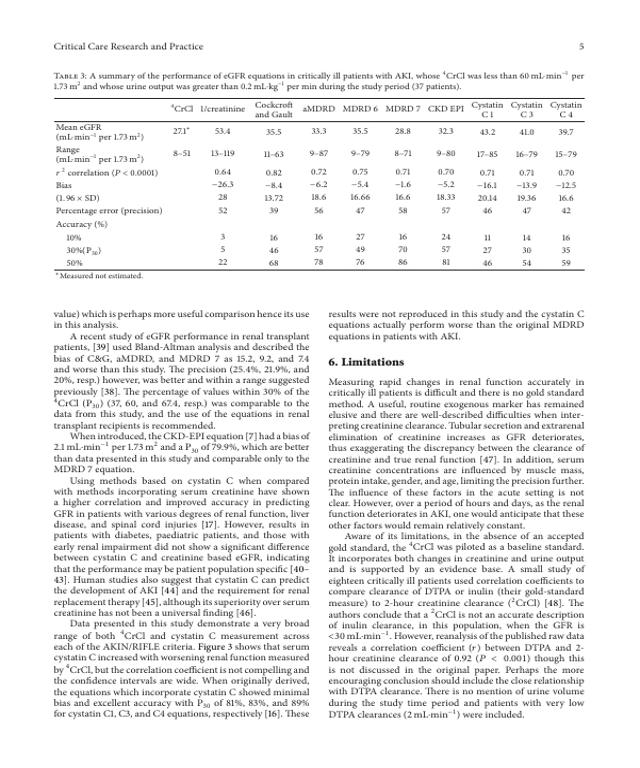

In [47]:
sample_img

In [48]:
sample_img_array = np.array(sample_img)

In [49]:
sample_img_array.shape

(768, 640, 3)

In [50]:
x = {}
x["image"] = transforms.ToTensor()(sample_img)
x["height"] = sample_img_array.shape[0]
x["width"] = sample_img_array.shape[1]

In [51]:
sample_batch = [x]

In [59]:
out = model_loaded(sample_batch)

/home/fjbriones/anaconda3/envs/instaseg/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/fjbriones/anaconda3/envs/instaseg/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [60]:
vis = Visualizer(sample_img)

In [61]:
out_image = vis.draw_instance_predictions(out[0]["instances"]).get_image()

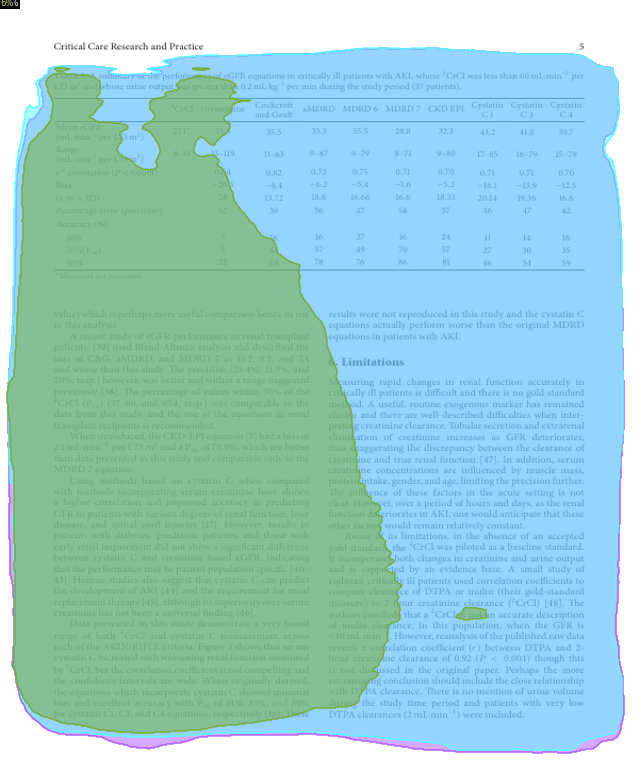

In [62]:
Image.fromarray(out_image)